In [1]:
import numpy as np
import pandas as pd 
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.activations import relu,linear
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#data cleaning
#df = pd.ExcelFile('C:/Users/halil/Desktop/soalr_data.xlsx').parse('sheet 1')
weather_raw = pd.read_excel('C:/Users/halil/Desktop/soalr_data.xlsx',sheet_name="weather")
guneko_raw = pd.read_excel('C:/Users/halil/Desktop/soalr_data.xlsx',sheet_name="1000255-GUNEKO")

guneko_production = guneko_raw[["Date","Production"]]
guneko_gti = guneko_raw[["Date.1","GTI"]]


weather_guneko = weather_raw.loc[weather_raw.name ==1000255]
ali = pd.merge(guneko_production,weather_guneko,left_on="Date",right_on="date")
dataset = ali.drop(["name","date","lat","lon"],axis=1)

In [3]:
#one hot encoding
df = dataset 

date_time = pd.to_datetime(df.pop('Date'), format='%d.%m.%Y %H:%M:%S')
timestamp_s = date_time.map(pd.Timestamp.timestamp)

day = 24*60*60
#month = day*30 
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

In [4]:
#normalization

train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

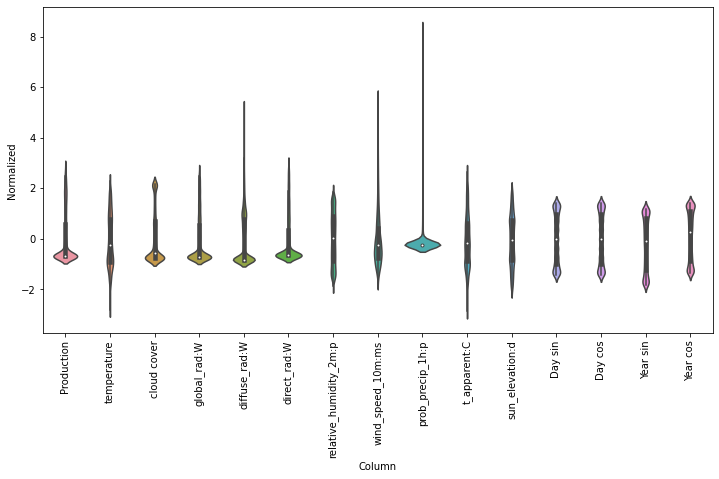

In [5]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

In [6]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [7]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [8]:
def plot(self, model=None, plot_col='Production', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

In [9]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [10]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [14]:
MAX_EPOCHS = 100
def compile_and_fit(model, window, patience=2):
  #early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=patience,mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),optimizer=tf.keras.optimizers.Adam(), metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,validation_data=window.val)
  return history

In [15]:
OUT_STEPS = 24
multi_window = WindowGenerator(input_width=24,label_width=OUT_STEPS,shift=OUT_STEPS)


In [18]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(OUT_STEPS*num_features,kernel_initializer=tf.initializers.zeros()),

    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

compile_and_fit(multi_dense_model, multi_window)

Epoch 1/20
415/415 [==============================] - 2s 3ms/step - loss: 0.2324 - mean_absolute_error: 0.2699 - val_loss: 0.1826 - val_mean_absolute_error: 0.2195
Epoch 2/20
415/415 [==============================] - 1s 3ms/step - loss: 0.1828 - mean_absolute_error: 0.2112 - val_loss: 0.1782 - val_mean_absolute_error: 0.2104
Epoch 3/20
415/415 [==============================] - 1s 3ms/step - loss: 0.1793 - mean_absolute_error: 0.2059 - val_loss: 0.1770 - val_mean_absolute_error: 0.2043
Epoch 4/20
415/415 [==============================] - 1s 3ms/step - loss: 0.1772 - mean_absolute_error: 0.2028 - val_loss: 0.1775 - val_mean_absolute_error: 0.2027
Epoch 5/20
415/415 [==============================] - 1s 3ms/step - loss: 0.1752 - mean_absolute_error: 0.2003 - val_loss: 0.1775 - val_mean_absolute_error: 0.2025


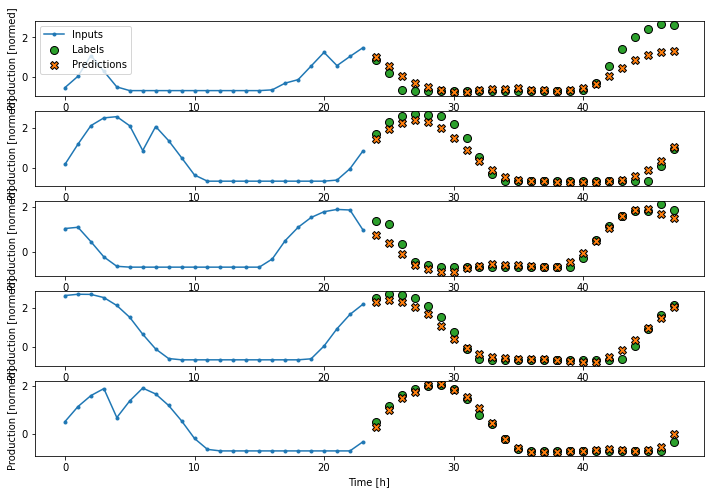

In [20]:
multi_window.plot(multi_dense_model,max_subplots=5)

In [ ]:
def residual_block(x):
  x_skip = x
  x = Dense(model_conf['neuron_size'],activation='relu',kernel_regularizer=model_conf['regulizer'])(x)
  x = BatchNormalization()(x)
  x = Dropout(model_conf['dropout'])(x)

  x = Dense(model_conf['neuron_size'],activation='relu',kernel_regularizer=model_conf['regulizer'])(x)
  x = BatchNormalization()(x)
  x = Dropout(model_conf['dropout'])(x)

  adding = Add()([x_skip,x])
  return Activation('relu')(adding)